From https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, regularizers
from tensorflow.keras import models
#import tensorflow_datasets as tfds

In [2]:
import ffmpeg
from pydub import AudioSegment

In [3]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'richfield_birds_split'
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category]
categories

['Common Buzzard',
 'Common Kestrel',
 'Common Snipe',
 'Eurasian Curlew',
 'European Herring Gull',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan',
 'Tundra Swan (Bewicks)']

In [4]:
AudioSegment.ffprobe  = "/usr/local/bin/ffmpeg"

In [5]:
#wav_check = 'birds'
#labels = os.listdir(wav_check)
#for lab in labels:
#    for sound_f in os.listdir(wav_check+'/'+lab):
#        pre, ext = os.path.splitext(wav_check+'/'+lab+'/'+sound_f)
#        if ext == '.wav':
#            continue
#        s_temp   = AudioSegment.from_file(pre+ext, ext[1:])
#        s_temp.export(pre+'.wav', format="wav")

In [6]:
#import re
#wav_check = 'birds'
#labels = os.listdir(wav_check)
#for lab in labels:
#    dirname = wav_check+'/'+lab
#    for sound_f in os.listdir(dirname):
#        if re.search('.wav', sound_f) == None:
#            os.remove(os.path.join(dirname, sound_f))

In [7]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [8]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
    #return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis
    return audio[:,0]

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [10]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
#filenames = tf.io.gfile.glob('birds/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)

In [11]:
filenames

<tf.Tensor: shape=(2840,), dtype=string, numpy=
array([b'richfield_birds_split\\Tundra Swan\\xc355233_start_0_15.wav',
       b'richfield_birds_split\\Common Kestrel\\xc636321_left_start_1_0.wav',
       b'richfield_birds_split\\Common Snipe\\xc675105_left_start_0_45.wav',
       ...,
       b'richfield_birds_split\\Tundra Swan\\xc293956_left_start_0_0.wav',
       b'richfield_birds_split\\Common Buzzard\\xc591116_start_2_45.wav',
       b'richfield_birds_split\\Rook\\xc481457_left_start_0_30.wav'],
      dtype=object)>

In [12]:
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(pathlib.Path(data_dir)/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 2840
Number of examples per label: 344
Example file tensor: tf.Tensor(b'richfield_birds_split\\Tundra Swan\\xc355233_start_0_15.wav', shape=(), dtype=string)


In [13]:
TRAIN_SIZE = 0.8

cutoff = int(len(filenames) * TRAIN_SIZE)
train_files = filenames[:cutoff]
test_files  = filenames[cutoff:]

print('Training set size:', len(train_files))
print('Validation set size:', len(test_files))

Training set size: 2272
Validation set size: 568


In [14]:
AUTOTUNE    = tf.data.experimental.AUTOTUNE
files_ds    = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

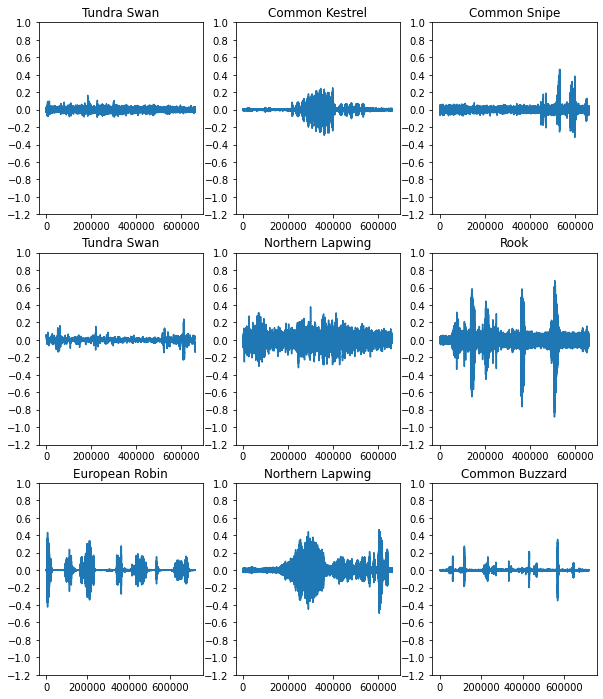

In [15]:
rows = 3
cols = 3
n    = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [16]:
#t_shapes = []
#for waveform, label in waveform_ds:
#    t_shapes.append(int(tf.shape(waveform)[0]))
#max_shape_pad = max(t_shapes)

In [17]:
#np.array(t_shapes).mean()

In [18]:
def get_spectrogram(waveform):
    #cutoff spectrogram size to either splice or pad
    #pad_cut  = tf.constant([1800, 2*129])
    waveform = tf.cast(waveform, tf.float32)
    
    # produces an array of complex numbers representing magnitude and phase
    spectrogram = tf.signal.stft(
        waveform, frame_length=int(0.01*4800), frame_step=2**12) #frame_step=1 would give spectrogram same length as audio plot

    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    
    #if length < pad_cut
    ## Concatenate with padding (close to 0) so that all specrograms will be of the same length 
    #else if length > pad_cut
    ## cut off anything in the spectrogram after pad_cut
    #zero_padding = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
    #                      lambda: tf.ones([1,1]), #some basic tensor, won't be used
    #                      lambda: tf.ones(pad_cut - tf.shape(spectrogram), dtype=tf.float32)*1e-8)
    #spectrogram = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
    #                      lambda: tf.slice(spectrogram, [0,0], [pad_cut[0], 129]), 
    #                      lambda: tf.concat([spectrogram, zero_padding], 0))

    return spectrogram

In [19]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Audio playback')
display.display(display.Audio(waveform, rate=48000))

Label: Tundra Swan
Waveform shape: (661500,)
Spectrogram shape: (162, 33)


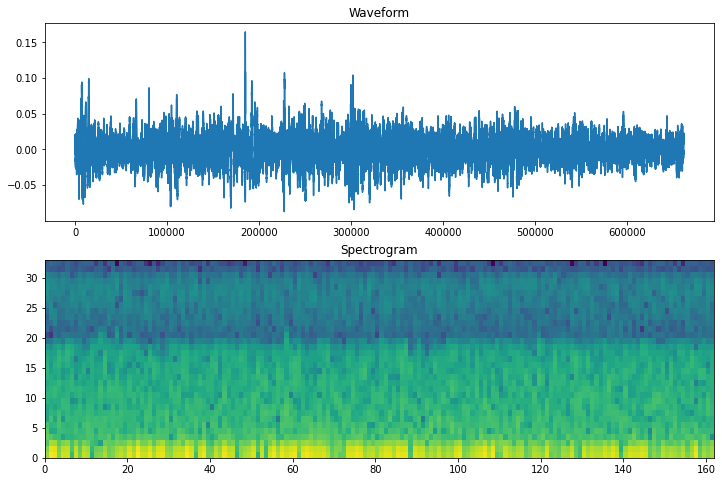

In [20]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    ax.pcolormesh(log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
#axes[0].set_xlim([0, 661500])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [21]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == categories)
    return spectrogram, label_id

In [22]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [23]:
def preprocess_dataset(files):
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [24]:
train_ds = spectrogram_ds
test_ds  = preprocess_dataset(test_files)

In [25]:
train_labs = [int(y) for _, y in train_ds]
test_labs  = [int(y) for _, y in test_ds]

In [26]:
train_labs_sort = train_labs
test_labs_sort  = test_labs
train_labs_sort.sort()
test_labs_sort.sort()

Text(0.5, 1.0, 'Test')

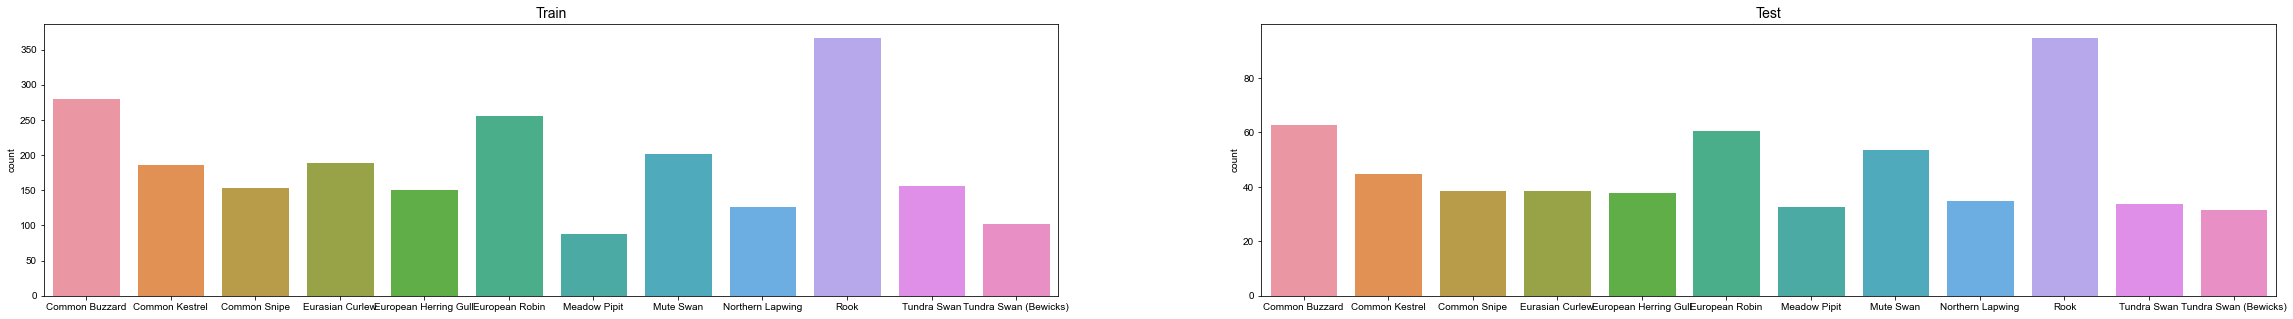

In [27]:
f, axes = plt.subplots(1, 2, figsize = (40,5))
l = []
for i in train_labs_sort:
    l.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = l, ax=axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize=8)
axes[0].set_title("Train", size = 14)

lt = []
for i in test_labs_sort:
    lt.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = lt, ax=axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize=10)
axes[1].set_title("Test", size = 14)

In [28]:
#test_files

In [29]:
batch_size = 32
train_ds   = train_ds.batch(batch_size)
test_ds    = test_ds.batch(batch_size)
train_ds   = train_ds.cache().prefetch(AUTOTUNE)
test_ds    = test_ds.cache().prefetch(AUTOTUNE)

In [30]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [31]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(categories)

Input shape: (162, 33, 1)


In [32]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

In [37]:
input_shape

TensorShape([162, 33, 1])

In [33]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [34]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [35]:
len(train_ds), len(test_ds)

(71, 18)

In [36]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10


InvalidArgumentError:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [176,33,1], [batch]: [162,33,1]
	 [[node IteratorGetNext (defined at <ipython-input-36-e0e0d880a889>:2) ]] [Op:__inference_train_function_7245]

Function call stack:
train_function


In [36]:
#history = model.fit(
#    train_ds, 
#    validation_data = test_ds,  
#    epochs          = EPOCHS,
#    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
#)

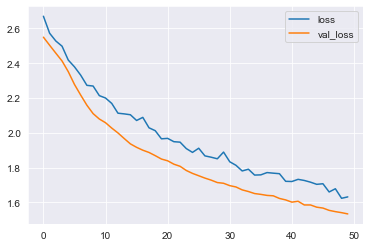

In [37]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

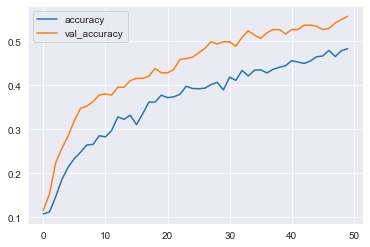

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [39]:
import plotly.graph_objs as go
metrics = history.history

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['loss'], 
                         mode = 'lines', name = 'Training',
                         line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_loss'], 
                         mode = 'lines', name = 'Validation',
                         line = dict(color='orange')))
fig.update_layout(title='Loss Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['accuracy'], 
                         mode = 'lines', name = 'Training',
                        line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_accuracy'], 
                         mode = 'lines', name = 'Validation',
                        line = dict(color='orange')))
fig.update_layout(title='Accuracy Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Accuracy')

fig.show()

In [42]:
from datetime import datetime

In [43]:
model.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net.h5')

In [44]:
#model = models.load('20211108_235747richfield_shallow_net')

In [45]:
#todo: confusion matrix and other 
y_pred = np.argmax(model.predict(test_ds), axis=-1)
y_true = [y for _,y in test_ds.unbatch()]

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[20,  1,  5,  7,  0,  1,  0,  1,  1,  0,  0,  0],
       [ 0, 22,  3,  0,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 1,  2, 17,  1,  1,  2,  0,  1,  2,  1,  1,  1],
       [ 1,  0,  9, 16,  0,  1,  1,  2,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 19,  0,  1,  1,  2,  2,  2,  0],
       [ 0,  4,  1,  0,  0, 24,  2,  3,  1,  0,  0,  0],
       [ 1,  2,  6,  0,  0,  6, 30,  1,  1,  0,  1,  0],
       [ 0,  0,  8,  1,  5,  1,  1, 12,  1,  5,  1,  2],
       [ 0,  4,  7,  0,  6,  3,  1,  0, 17,  1,  1,  0],
       [ 0,  1,  5,  2,  1,  0,  0,  2,  0, 25,  1,  2],
       [ 1,  0,  4,  0,  0,  0,  0,  3,  0,  1, 12,  2],
       [ 0,  0,  3,  0,  2,  0,  0,  0,  0,  0, 12,  7]], dtype=int64)

In [61]:
import plotly.figure_factory as ff

z = cm

x = categories
y = categories
#y.reverse()

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion<br>matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                  yaxis=dict(autorange='reversed'),
                  title_x=0
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.26,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [62]:
fig.write_html('confusion_matrix'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net.html')

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_pred_proba = model.predict(test_ds)[::,1]
#fpr, tpr, _  = roc_curve(y_true,  y_pred_proba)

In [64]:
pred_lists = model.predict(test_ds)

In [65]:
pred_df = pd.DataFrame(pred_lists, columns = categories)

In [66]:
pred_df_softmax = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)

In [67]:
#pred_df_softmax.to_numpy()

In [68]:
from sklearn.preprocessing import OneHotEncoder
onehot_data = OneHotEncoder(sparse=False)
onehot_data = onehot_data.fit_transform(np.array(y_true).reshape(len(y_true),1))

In [69]:
#onehot_data
from itertools import cycle

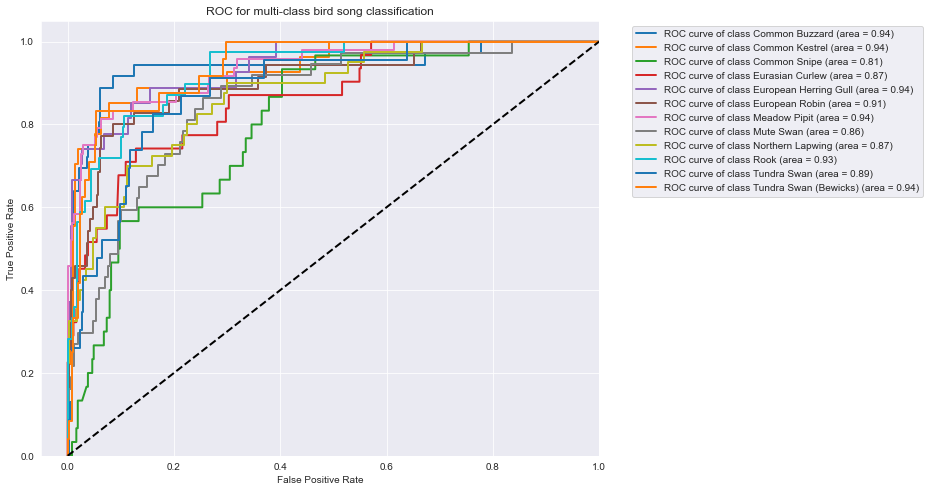

In [70]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(categories)
lw = 2
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(onehot_data[:, i], pred_df_softmax.to_numpy()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             #color=color, 
             lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class bird song classification')
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1))#, loc='upper right')
plt.show()

In [71]:
for i in range(n_classes):
    print('AUC of {0}: \t{1:0.2f}'.format(categories[i], roc_auc[i]))

AUC of Common Buzzard: 	0.94
AUC of Common Kestrel: 	0.94
AUC of Common Snipe: 	0.81
AUC of Eurasian Curlew: 	0.87
AUC of European Herring Gull: 	0.94
AUC of European Robin: 	0.91
AUC of Meadow Pipit: 	0.94
AUC of Mute Swan: 	0.86
AUC of Northern Lapwing: 	0.87
AUC of Rook: 	0.93
AUC of Tundra Swan: 	0.89
AUC of Tundra Swan (Bewicks): 	0.94


In [72]:
fig = go.Figure()
#colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i in range(n_classes):
    fig.add_trace(go.Scatter(x = fpr[i], y = tpr[i], 
                             mode = 'lines', 
                             name = 'ROC curve of {0} (area = {1:0.2f})'.format(categories[i], roc_auc[i])))
fig.update_layout(title       = 'ROC for multi-class bird song classification',
                  xaxis_title = 'False Positive Rate',
                  yaxis_title = 'True Positive Rate')

fig.show()

In [ ]:
#Now create multi-channel features
def get_spectrogram(waveform):
    #cutoff spectrogram size to either splice or pad
    pad_cut  = tf.constant([1800, 2*129])
    waveform = tf.cast(waveform, tf.float32)
    
    # produces an array of complex numbers representing magnitude and phase
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128) #frame_step=1 would give spectrogram same length as audio plot

    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    
    #if length < pad_cut
    ## Concatenate with padding (close to 0) so that all specrograms will be of the same length 
    #else if length > pad_cut
    ## cut off anything in the spectrogram after pad_cut
    zero_padding = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
                          lambda: tf.ones([1,1]), #some basic tensor, won't be used
                          lambda: tf.ones(pad_cut - tf.shape(spectrogram), dtype=tf.float32)*1e-8)
    spectrogram = tf.cond(tf.shape(spectrogram)[0] > pad_cut[0], 
                          lambda: tf.slice(spectrogram, [0,0], [pad_cut[0], 129]), 
                          lambda: tf.concat([spectrogram, zero_padding], 0))

    return spectrogram